# Hybrid Deep Model: Visualization and Metrics

> Use this notebook to visualize experiment outputs (baselines and the hybrid CNN–BiLSTM–Self-Attention model) and inspect metrics, score distributions, and attention maps when available.

What you can do here:
- Load a metrics summary if present in `output/metrics_summary.csv` and plot key metrics.
- Explore score/prediction distributions for available outputs in `output/`.
- If you trained the hybrid model and exported attention, visualize attention heatmaps.

Notes:
- This notebook is robust to missing files. It will skip plots if it can’t find the expected artifacts.
- To generate artifacts, run the experiment scripts (e.g., `run_experiments.ps1`) or run the hybrid script directly (see the last section for tips).

In [17]:
# Imports and setup
import os
import glob
import json
import math
import textwrap
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# Plot style
sns.set_context("talk")
sns.set_style("whitegrid")

ROOT = Path.cwd()
OUTPUT_DIR = ROOT / "output"
INDEX_DIR = ROOT / "index"

print(f"Workspace: {ROOT}")
print(f"Looking for outputs in: {OUTPUT_DIR}")
OUTPUT_DIR.mkdir(exist_ok=True)

Workspace: c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research
Looking for outputs in: c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output


In [18]:
# Helper functions
def safe_read_csv(path: Path, **kwargs):
    try:
        if path.exists():
            return pd.read_csv(path, **kwargs)
    except Exception as e:
        print(f"Failed to read {path}: {e}")
    return None

def find_output_files(patterns):
    files = []
    for pat in patterns:
        files.extend(glob.glob(str(OUTPUT_DIR / pat)))
    return sorted(set(files))

def show_section(title):
    display(Markdown(f"## {title}"))

def pct(x):
    return f"{100.0 * x:.1f}%"

In [19]:
# 1) Load metrics summary if available
metrics_path = OUTPUT_DIR / "metrics_summary.csv"
metrics_md_path = OUTPUT_DIR / "metrics_summary.md"
metrics_df = safe_read_csv(metrics_path)

if metrics_df is not None and len(metrics_df) > 0:
    show_section("Metrics summary")
    display(metrics_df)
else:
    show_section("Metrics summary")
    display(Markdown("No metrics_summary.csv found. Run the parser after experiments to generate it."))
    print(f"Expected at: {metrics_path}")

if metrics_md_path.exists():
    show_section("Metrics summary (Markdown)")
    try:
        with open(metrics_md_path, "r", encoding="utf-8") as f:
            md_text = f.read()
        display(Markdown(md_text))
    except Exception as e:
        print(f"Failed to open metrics_summary.md: {e}")

## Metrics summary

,model,n,tp,fp,fn,tn,precision,recall,f1,accuracy
0,autoencoder_A,0,0,0,0,0,0.0,0.0,0.0,0.000000
1,autoencoder_B,0,0,0,0,0,0.0,0.0,0.0,0.000000
2,csr_A,2,2,0,0,0,1.0,1.0,1.0,1.000000
3,csr_B,2,2,0,0,0,1.0,1.0,1.0,1.000000
4,hybrid,0,0,0,0,0,0.0,0.0,0.0,0.000000
5,iforest_A,0,0,0,0,0,0.0,0.0,0.0,0.000000
6,iforest_B,0,0,0,0,0,0.0,0.0,0.0,0.000000
7,lstm,24,0,0,2,22,0.0,0.0,0.0,0.916667
8,multi_pred_A,2,0,0,2,0,0.0,0.0,0.0,0.000000
9,multi_pred_B,2,0,0,2,0,0.0,0.0,0.0,0.000000


## Metrics summary (Markdown)

# Metrics Summary

| Model | N | TP | FP | FN | TN | Precision | Recall | F1 | Accuracy |
|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| autoencoder_A | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| autoencoder_B | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| csr_A | 2 | 2 | 0 | 0 | 0 | 1.000 | 1.000 | 1.000 | 1.000 |
| csr_B | 2 | 2 | 0 | 0 | 0 | 1.000 | 1.000 | 1.000 | 1.000 |
| hybrid | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| iforest_A | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| iforest_B | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| lstm | 24 | 0 | 0 | 2 | 22 | 0.000 | 0.000 | 0.000 | 0.917 |
| multi_pred_A | 2 | 0 | 0 | 2 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| multi_pred_B | 2 | 0 | 0 | 2 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| patchTST | 24 | 0 | 0 | 2 | 22 | 0.000 | 0.000 | 0.000 | 0.917 |
| svm_A | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| svm_B | 0 | 0 | 0 | 0 | 0 | 0.000 | 0.000 | 0.000 | 0.000 |
| iforest_output | 94 | 0 | 5 | 0 | 89 | 0.000 | 0.000 | 0.000 | 0.947 |
| svm_output | 94 | 0 | 35 | 0 | 59 | 0.000 | 0.000 | 0.000 | 0.628 |

## Metrics bar plots

C:\Users\Jludo\AppData\Local\Temp\ipykernel_1800\2474298043.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(data=melted, kind="bar", x="metric", y="value", hue=id_cols[0] if id_cols else None, ci=None)


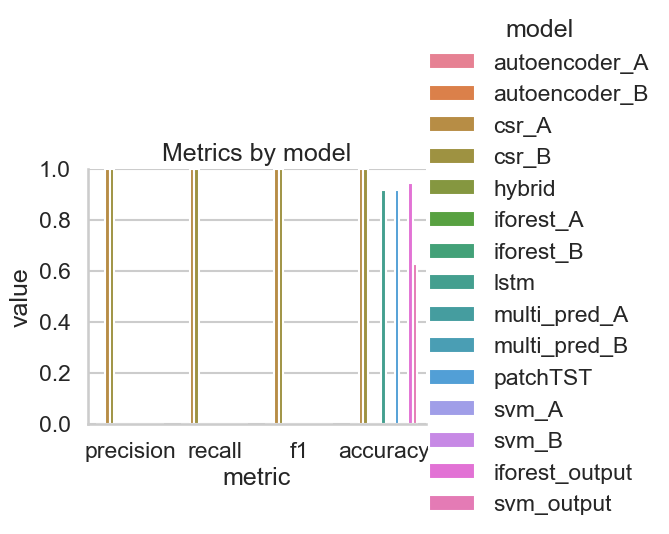

In [20]:
# 2) Plot key metrics if present
if metrics_df is not None and len(metrics_df) > 0:
    plot_cols = [c for c in metrics_df.columns if c.lower() in {"precision","recall","f1","auroc","accuracy"}]
    id_cols = [c for c in ["model","variant","dataset","split"] if c in metrics_df.columns]
    melted = metrics_df.melt(id_vars=id_cols, value_vars=plot_cols, var_name="metric", value_name="value")
    if len(melted) > 0:
        show_section("Metrics bar plots")
        g = sns.catplot(data=melted, kind="bar", x="metric", y="value", hue=id_cols[0] if id_cols else None, ci=None)
        plt.ylim(0, 1)
        plt.title("Metrics by model")
        plt.show()
    else:
        print("No recognized metric columns to plot.")

In [21]:
# 3) Explore available prediction outputs
csv_candidates = find_output_files(["*_output*.csv","*parsed*.csv","*.out"])
show_section("Available output files")
display(pd.DataFrame({"file": csv_candidates}))

def load_predictions(path):
    p = Path(path)
    if p.suffix == ".out":
        # Text outputs: try common patterns
        try:
            lines = Path(path).read_text(encoding="utf-8", errors="ignore").splitlines()
        except Exception:
            return None
        rows = []
        for ln in lines:
            if not ln.strip():
                continue
            # Heuristic: look for key=value pairs or CSV-like pieces
            parts = [seg.strip() for seg in ln.replace(","," ").split()]
            rec = {}
            for seg in parts:
                if "=" in seg:
                    k,v = seg.split("=",1)
                    rec[k.strip()] = v.strip()
            if rec:
                rows.append(rec)
        if rows:
            return pd.DataFrame(rows)
        return None
    else:
        return safe_read_csv(p)

pred_dfs = {}
for f in csv_candidates:
    df = load_predictions(f)
    if df is not None and len(df) > 0:
        pred_dfs[f] = df.head(5)

if pred_dfs:
    show_section("Preview: first rows of detected outputs")
    for k, v in pred_dfs.items():
        display(Markdown(f"**{k}**"))
        display(v)
else:
    print("No parseable outputs detected.")

## Available output files

,file
0,c:\Users\Jludo\OneDrive - The University of Te...
1,c:\Users\Jludo\OneDrive - The University of Te...
2,c:\Users\Jludo\OneDrive - The University of Te...
3,c:\Users\Jludo\OneDrive - The University of Te...
4,c:\Users\Jludo\OneDrive - The University of Te...
5,c:\Users\Jludo\OneDrive - The University of Te...
6,c:\Users\Jludo\OneDrive - The University of Te...
7,c:\Users\Jludo\OneDrive - The University of Te...
8,c:\Users\Jludo\OneDrive - The University of Te...
9,c:\Users\Jludo\OneDrive - The University of Te...


Failed to read c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\autoencoder_A_parsed.csv: No columns to parse from file
Failed to read c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\autoencoder_B_parsed.csv: No columns to parse from file
Failed to read c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\hybrid_parsed.csv: No columns to parse from file
Failed to read c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\iforest_A_parsed.csv: No columns to parse from file
Failed to read c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmark

## Preview: first rows of detected outputs

**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\csr_A_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,NaN,True
1,2025-10-09,cluster_B,host_synth1,disk1,NaN,True


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\csr_B_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,NaN,True
1,2025-10-09,cluster_B,host_synth1,disk1,NaN,True


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\hybrid.out**

, o b j . i n f e r _ o b j e c t s ( c o p y , , g . a s f r e q ( ' 1 5 s ' ) . i n t e r p o l a t e ( l i m i t _ d i r e c t i o n , T r a i n C o n f i g ( b a t c h _ s i z e , c l a s s _ w e i g h t s 
0, F a l s e ) ,NaN,NaN,NaN,NaN
1,NaN, , ' b o t h ' ) ,NaN,NaN
2, F a l s e ) ,NaN,NaN,NaN,NaN
3,NaN, , ' b o t h ' ) ,NaN,NaN
4,NaN, ,NaN, b a t c h _ s i z e ) , c w ) 


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\iforest_output.csv**

,Date,Cluster,Host,Disk,Prediction,anomaly_score,score
0,2025-10-09,cluster_B,host_1,disk1,False,-0.025874,0.619099
1,2025-10-09,cluster_B,host_10,disk1,False,-0.059564,0.342366
2,2025-10-09,cluster_B,host_11,disk1,True,0.003244,0.858279
3,2025-10-09,cluster_B,host_12,disk1,False,-0.032580,0.564015
4,2025-10-09,cluster_B,host_13,disk1,False,-0.033947,0.552793


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\iforest_output_parsed.csv**

,date,cluster,host,disk,score,score.1,pred
0,2025-10-09,cluster_B,host_1,disk1,-0.041891,0.500817,False
1,2025-10-09,cluster_B,host_10,disk1,-0.054515,0.390088,False
2,2025-10-09,cluster_B,host_11,disk1,-0.037566,0.538753,False
3,2025-10-09,cluster_B,host_12,disk1,-0.084144,0.130191,False
4,2025-10-09,cluster_B,host_13,disk1,-0.069398,0.259542,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\lstm_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,1.723113,False
1,2025-10-09,cluster_A,host_synth1,disk2,0.000000,False
2,2025-10-09,cluster_A,host_synth1,disk3,0.000000,False
3,2025-10-09,cluster_A,host_synth1,disk4,0.000000,False
4,2025-10-09,cluster_A,host_synth1,disk5,0.000000,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\multi_pred_A_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,NaN,False
1,2025-10-09,cluster_B,host_synth1,disk1,NaN,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\multi_pred_B_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,NaN,False
1,2025-10-09,cluster_B,host_synth1,disk1,NaN,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\patchTST_parsed.csv**

,date,cluster,host,disk,score,pred
0,2025-10-09,cluster_A,host_synth1,disk1,3.965353,False
1,2025-10-09,cluster_A,host_synth1,disk2,0.000000,False
2,2025-10-09,cluster_A,host_synth1,disk3,0.000000,False
3,2025-10-09,cluster_A,host_synth1,disk4,0.000000,False
4,2025-10-09,cluster_A,host_synth1,disk5,0.000000,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\svm_output.csv**

,Date,Cluster,Host,Disk,probability,score,Prediction,anomaly_score,score_threshold,confidence
0,2025-10-09,cluster_B,host_1,disk1,0.305433,0.305433,False,-0.033062,0.000201,0.508315
1,2025-10-09,cluster_B,host_10,disk1,0.746003,0.746003,False,-0.011767,0.000201,0.502992
2,2025-10-09,cluster_B,host_11,disk1,0.993438,0.993438,True,0.000192,0.000201,0.500002
3,2025-10-09,cluster_B,host_12,disk1,0.989549,0.989549,True,0.000004,0.000201,0.500049
4,2025-10-09,cluster_B,host_13,disk1,0.986096,0.986096,True,-0.000163,0.000201,0.500091


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\svm_output_cluster_A_example_day_parsed.csv**

,date,cluster,host,disk,score,pred
0,2024-11-23,cluster_A,host_1,disk1,NaN,False
1,2024-11-23,cluster_A,host_10,disk1,NaN,True
2,2024-11-23,cluster_A,host_11,disk1,NaN,False
3,2024-11-23,cluster_A,host_12,disk1,NaN,False
4,2024-11-23,cluster_A,host_13,disk1,NaN,False


**c:\Users\Jludo\OneDrive - The University of Texas at Austin\AI 391M - Case Studies in Machine Learning\FSA-benchmarking-Reproduction-Research\output\svm_output_parsed.csv**

,date,cluster,host,disk,score,score.1,score.2,pred
0,2025-10-09,cluster_B,host_1,disk1,0.305433,0.305433,-0.033062,False
1,2025-10-09,cluster_B,host_10,disk1,0.746003,0.746003,-0.011767,False
2,2025-10-09,cluster_B,host_11,disk1,0.993438,0.993438,0.000192,True
3,2025-10-09,cluster_B,host_12,disk1,0.989549,0.989549,0.000004,True
4,2025-10-09,cluster_B,host_13,disk1,0.986096,0.986096,-0.000163,True


## iforest_output.csv Score distribution: score

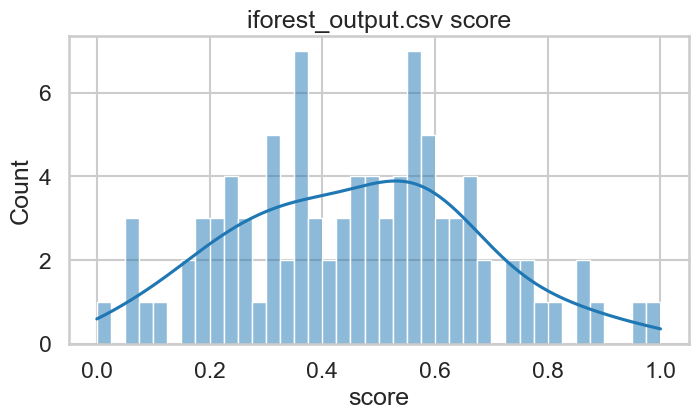

## iforest_output.csv Score distribution: anomaly_score

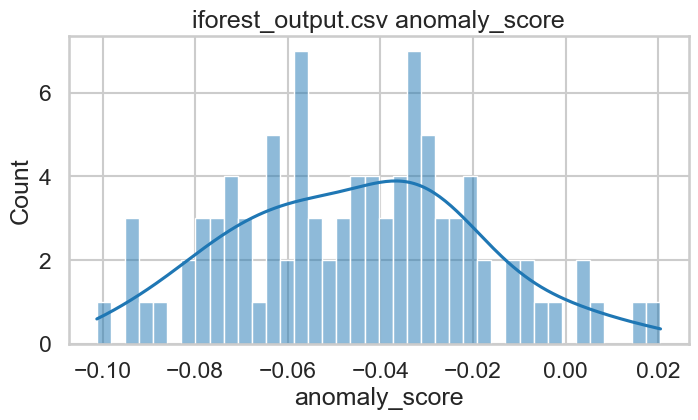

## svm_output.csv Score distribution: score

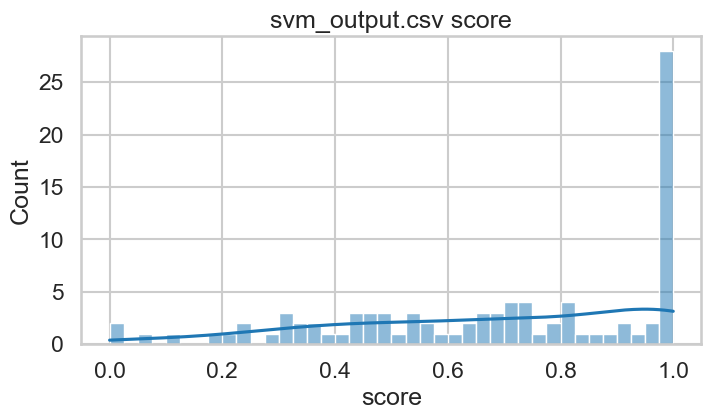

## svm_output.csv Score distribution: anomaly_score

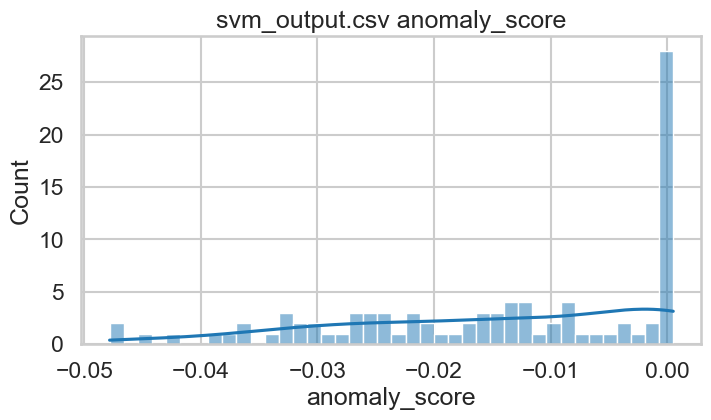

In [22]:
# 4) Score distributions for key outputs if present
def plot_score_distribution(df, title_prefix="", score_cols=("score","prob","anomaly_score")):
    for sc in score_cols:
        if sc in df.columns:
            show_section(f"{title_prefix}Score distribution: {sc}")
            plt.figure(figsize=(8,4))
            try:
                vals = pd.to_numeric(df[sc], errors="coerce").dropna()
            except Exception:
                vals = df[sc]
            sns.histplot(vals, bins=40, kde=True)
            plt.title(f"{title_prefix}{sc}")
            plt.show()

# Common outputs from this project
targets = [
    OUTPUT_DIR / "iforest_output.csv",
    OUTPUT_DIR / "svm_output.csv",
    OUTPUT_DIR / "autoencoder_output.csv",
    OUTPUT_DIR / "autoencoder_output_A_index.csv",
    OUTPUT_DIR / "autoencoder_output_B_index.csv",
    OUTPUT_DIR / "patchTST.out",
    OUTPUT_DIR / "lstm.out",
    OUTPUT_DIR / "multi_pred_A.out",
    OUTPUT_DIR / "multi_pred_B.out",
    OUTPUT_DIR / "csr_A.out",
    OUTPUT_DIR / "csr_B.out",
    OUTPUT_DIR / "GPT-4_A.out",
    OUTPUT_DIR / "GPT-4_B.out",
]

for t in targets:
    if t.exists():
        df = load_predictions(t)
        if df is not None and len(df) > 0:
            title = f"{t.name} "
            plot_score_distribution(df, title_prefix=title)

## Hybrid predictions (head)

,host,disk_id,t_end,y_true,y_prob,y_pred
0,host_synth1,disk1,2025-10-09 00:04:45+00:00,0.0,1.0,1
1,host_synth1,disk1,2025-10-09 00:05:00+00:00,0.0,1.0,1
2,host_synth1,disk1,2025-10-09 00:05:15+00:00,0.0,1.0,1
3,host_synth1,disk1,2025-10-09 00:05:30+00:00,0.0,1.0,1
4,host_synth1,disk1,2025-10-09 00:05:45+00:00,0.0,1.0,1


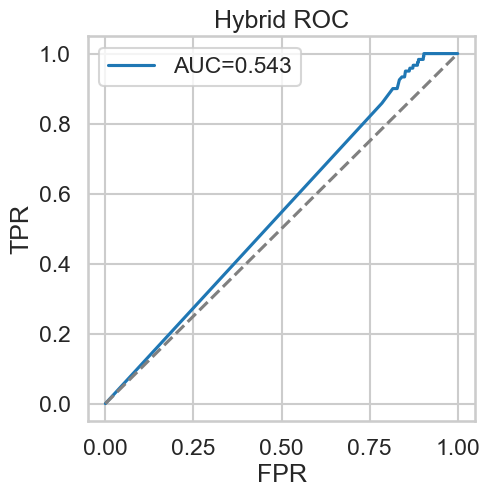

## Hybrid attention maps

Attention array shape: (5726, 2, 2)


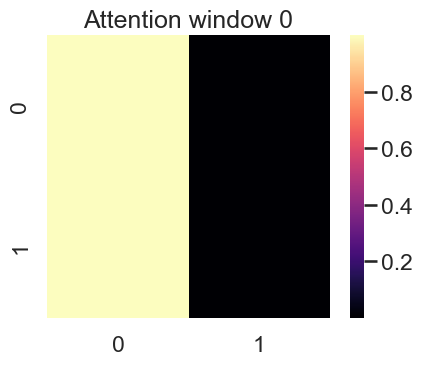

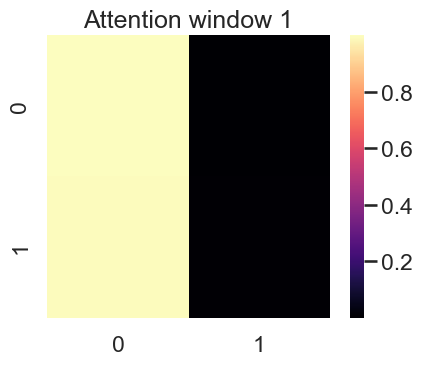

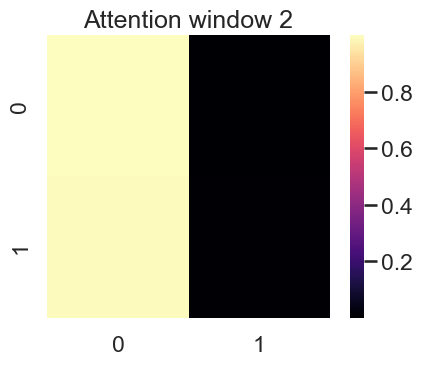

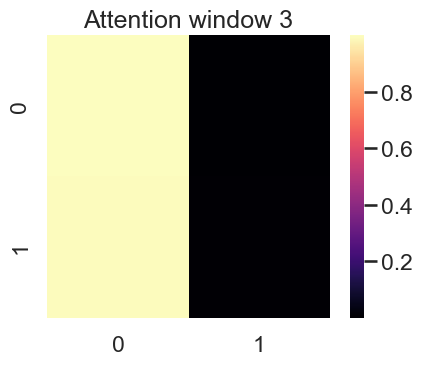

## Hybrid meta

,metrics
0,"[latency, throughput]"


In [23]:
# 5) Hybrid model artifacts: predictions and attention
hybrid_pred_csv = OUTPUT_DIR / "hybrid_predictions.csv"
hybrid_attn_npy = OUTPUT_DIR / "hybrid_attention.npy"
hybrid_meta_json = OUTPUT_DIR / "hybrid_meta.json"

hybrid_df = safe_read_csv(hybrid_pred_csv)
if hybrid_df is not None and len(hybrid_df) > 0:
    show_section("Hybrid predictions (head)")
    display(hybrid_df.head())
    # Plot ROC-like curve if score + label exist (support multiple column name variants)
    cols = set(hybrid_df.columns)
    y_score_col = 'score' if 'score' in cols else ('y_prob' if 'y_prob' in cols else None)
    y_label_col = 'label' if 'label' in cols else ('y_true' if 'y_true' in cols else None)
    if y_score_col and y_label_col:
        try:
            from sklearn.metrics import roc_curve, auc
            y_true = hybrid_df[y_label_col].astype(int)
            y_score = hybrid_df[y_score_col].astype(float)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,5))
            plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
            plt.plot([0,1],[0,1], linestyle="--", color="gray")
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title("Hybrid ROC")
            plt.legend()
            plt.show()
        except Exception as e:
            print("sklearn not available or ROC calc failed:", e)
else:
    show_section("Hybrid predictions")
    display(Markdown("No hybrid_predictions.csv found yet."))

# Attention visualization
if hybrid_attn_npy.exists():
    show_section("Hybrid attention maps")
    try:
        arr = np.load(hybrid_attn_npy, allow_pickle=True)
        if isinstance(arr, np.ndarray):
            print("Attention array shape:", arr.shape)
            # Pick a few windows to visualize
            n_show = min(4, len(arr)) if getattr(arr, 'ndim', 0) >= 2 else 0
            for i in range(n_show):
                plt.figure(figsize=(5,4))
                A = arr[i]
                # If heads dimension remains (H, T, T), average over heads
                if getattr(A, 'ndim', 0) == 3:
                    A = A.mean(axis=0)
                sns.heatmap(A, cmap="magma", square=True)
                plt.title(f"Attention window {i}")
                plt.tight_layout()
                plt.show()
        else:
            print("Unexpected attention data type.")
    except Exception as e:
        print(f"Failed to load attention: {e}")
else:
    show_section("Hybrid attention maps")
    display(Markdown("No hybrid_attention.npy found yet."))

# Meta info
if hybrid_meta_json.exists():
    try:
        meta = json.loads(hybrid_meta_json.read_text(encoding="utf-8"))
        show_section("Hybrid meta")
        display(pd.json_normalize(meta))
    except Exception as e:
        print("Failed to read hybrid_meta.json:", e)

## Feature attention (per-window, averaged over time)

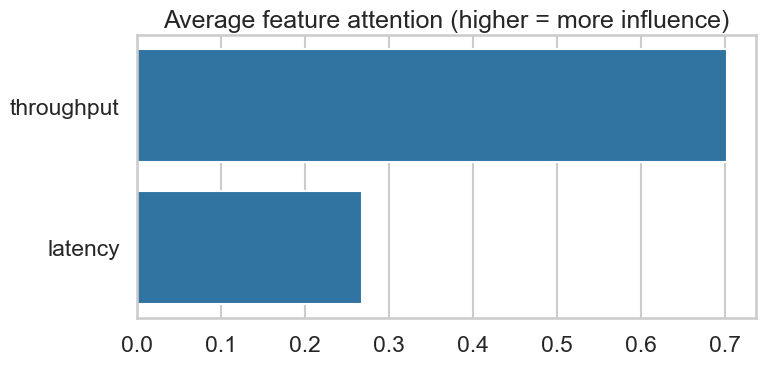

In [24]:
# 6) Feature attention visualization (per-metric gating)
feat_attn = OUTPUT_DIR / 'hybrid_feature_attention.npy'
if feat_attn.exists():
    show_section('Feature attention (per-window, averaged over time)')
    try:
        A = np.load(feat_attn, allow_pickle=True)
        metrics = []
        if (OUTPUT_DIR / 'hybrid_meta.json').exists():
            try:
                meta = json.loads((OUTPUT_DIR / 'hybrid_meta.json').read_text(encoding='utf-8'))
                metrics = meta.get('metrics', metrics)
            except Exception:
                pass
        # Show mean importance across windows
        if isinstance(A, np.ndarray) and A.ndim == 2:
            mean_imp = A.mean(axis=0)
            idx = np.argsort(-mean_imp)
            names = [metrics[i] if i < len(metrics) else f'm{i}' for i in idx]
            vals = mean_imp[idx]
            plt.figure(figsize=(8,4))
            sns.barplot(x=vals, y=names, orient='h')
            plt.title('Average feature attention (higher = more influence)')
            plt.tight_layout()
            plt.show()
        else:
            print('Unexpected feature attention shape:', getattr(A, 'shape', None))
    except Exception as e:
        print('Failed to load feature attention:', e)
else:
    show_section('Feature attention')
    display(Markdown('No hybrid_feature_attention.npy found yet.'))

## Hybrid AUROC diagnostics

,precision,recall,f1,auroc,accuracy,auroc_inverse,precision_at_recall_0_80,threshold_at_recall_0_80,time_to_alert_min
0,0.020957,1.0,0.041054,0.543472,0.020957,0.543472,0.023318,1.0,0.0


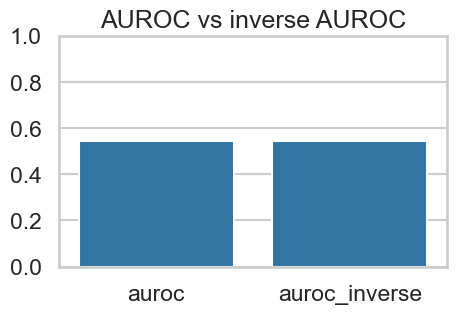

In [25]:
# 7) AUROC vs inverse AUROC (diagnostics)
hybrid_metrics_csv = OUTPUT_DIR / "hybrid_metrics.csv"
if hybrid_metrics_csv.exists():
    show_section("Hybrid AUROC diagnostics")
    try:
        mdf = pd.read_csv(hybrid_metrics_csv)
        if {"auroc","auroc_inverse"}.issubset(mdf.columns):
            display(mdf[[c for c in mdf.columns if c in ["precision","recall","f1","accuracy","auroc","auroc_inverse","precision_at_recall_0_80","threshold_at_recall_0_80","time_to_alert_min"]]])
            vals = mdf.iloc[0]
            au, au_inv = float(vals.get("auroc", 0.0)), float(vals.get("auroc_inverse", 0.0))
            plt.figure(figsize=(5,3))
            sns.barplot(x=["auroc","auroc_inverse"], y=[au, au_inv])
            plt.ylim(0,1)
            plt.title("AUROC vs inverse AUROC")
            plt.show()
        else:
            print("hybrid_metrics.csv does not contain auroc columns.")
    except Exception as e:
        print("Failed to load hybrid_metrics.csv:", e)
else:
    show_section("Hybrid AUROC diagnostics")
    display(Markdown("No hybrid_metrics.csv found yet."))